### Data Cleaning

It is commonly said that data scientists spend 80% of their time cleaning data. The rest 20% used to go to model training but these days are more towards complaining to have the clean the data. 

In this week, we will continue working with pandas and try to face and solve some common data cleaning issues, such as:
- Parsing dates
- Missing data and imputation of missing data
- Renaming columns
- Changing values of categories of columns
- Creating new features (from existing columns)
- Fuzzy string matching


We will start with the 'San Francisco Building Permits' data from Kaggle: https://www.kaggle.com/aparnashastry/building-permit-applications-data 

Please download it and let's import it.

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fuzzywuzzy

In [117]:
!pip install fuzzywuzzy

In [2]:
df = pd.read_csv('Building_Permits.csv')

C:\Users\mishe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [4]:
# Brief look at the types of data  (we also see many missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Permit Number                           198900 non-null  object 
 1   Permit Type                             198900 non-null  int64  
 2   Permit Type Definition                  198900 non-null  object 
 3   Permit Creation Date                    198900 non-null  object 
 4   Block                                   198900 non-null  object 
 5   Lot                                     198900 non-null  object 
 6   Street Number                           198900 non-null  int64  
 7   Street Number Suffix                    2216 non-null    object 
 8   Street Name                             198900 non-null  object 
 9   Street Suffix                           196132 non-null  object 
 10  Unit                                    2947

### Date parsing

Working with dates is super common. Python often reads dates as 'objects' (unless you specifically assign the parse_dates argument in the .read_csv(), for example. 

Dates can often function as an index in a DataFrame or in general help us calculate useful information (which days of the week see most a peak in purchases, which weeks of the year witness a peak of holiday bookings, how long has a house been on the market, etc, etc. 

**Q1. In this exercise transform the 'Permit Creation Date' column to a datetime64 type and TRY to make sure the format is '%d-%m-%y'.
Note: the tricky part is to retain the column as datetime and change the displayed format.**

In [20]:
# Change to datetime
df['Permit Creation Date'] = pd.to_datetime(df['Permit Creation Date'])
print('Column has changed to:  \n', df['Permit Creation Date'].head())

# To change the format of the datetime displayed, we use the .strftime method, which transforms the datetime back to string but formats it
# in a desirable way
df['Permit Creation Date'] = df['Permit Creation Date'].dt.strftime('%d-%m-%y')
print('\nFormat changed: \n', df['Permit Creation Date'].head())
print('\ncolumn type has changed to: ', df['Permit Creation Date'].dtype)

Column has changed to:  
 0   2015-05-06
1   2016-04-19
2   2016-05-27
3   2016-11-07
4   2016-11-28
Name: Permit Creation Date, dtype: datetime64[ns]

Format changed: 
 0    06-05-15
1    19-04-16
2    27-05-16
3    07-11-16
4    28-11-16
Name: Permit Creation Date, dtype: object

column type has changed to:  object


Normally, we'd transform the column to a **datetime** and create new useful features using the datetime column.

**Q2. Create a feature for the year and the month of the created permit. Plot them each to see if there is a change/trend in the permits given over the years or the different months.**

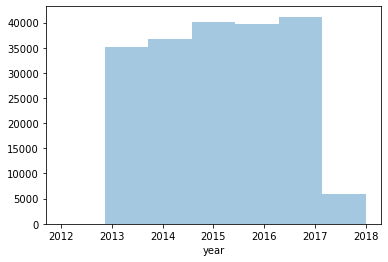

In [41]:
# Create features for month and year
df['month'] = df['Permit Creation Date'].dt.month
df['year'] = df['Permit Creation Date'].dt.year

# Simple histogram of permits per year 
sns.distplot(df['year'], bins=7, kde=False) 

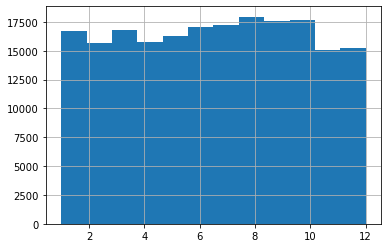

In [38]:
df['month'].hist(bins=12)

**Q3. We see that all the column names are capitalized. Let's make them all lowercase and replace empty string with a _, so that a 'Permit Number' will become 'permit_number'**

In [45]:
# Solution with a list comprehension
new_cols = [col.lower().replace(' ', '_') for col in df.columns]
df.columns = new_cols
df.head()

,permit_number,permit_type,permit_type_definition,permit_creation_date,block,lot,street_number,street_number_suffix,street_name,street_suffix,...,proposed_construction_type,proposed_construction_type_description,site_permit,supervisor_district,neighborhoods_-_analysis_boundaries,zipcode,location,record_id,month,year
0,201505065519,4,sign - erect,2015-06-05,0326,023,140,NaN,Ellis,St,...,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945,6,2015
1,201604195146,4,sign - erect,2016-04-19,0306,007,440,NaN,Geary,St,...,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718,4,2016
2,201605278609,3,additions alterations or repairs,2016-05-27,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716,5,2016
3,201611072166,8,otc alterations permit,2016-07-11,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566,7,2016
4,201611283529,6,demolitions,2016-11-28,0342,001,950,NaN,Market,St,...,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992,11,2016


### Missing values

**Q4. Find out what percentage of the data is missing (across all the data).** 

*Fun fact: .isna() and .isnull() both work *

In [50]:
df.isnull().sum().sum() / (df.shape[0]*df.shape[1])

0.25092911010558067

The first part finds the total number of missing values across the data set. We divide that by the total number of data entry points (i.e. rows multiplied by columns). In this case, around 25% of the data is missing, which is substantial. 

There are many reasons why the data could be missing. The main distinction you may want to make is:
**- Is the data missing because it was not recorded or because the value does not exist?**

If the data is missing because the VALUE DOES NOT EXIST (such as the number of children in an income tax form for someone with no kids), then you may want to keep it missing. 

If the value is missing because it was NOT RECORDED, then you may want to impute it. Common imputation approaches:
- Replace all missing values with 0s
- Replace all missing values with a statistical measure (the mean, median, mode) 
- Algorithmically (for example, predict a binary value using a classification task and a quantitative value using a regression task). 

We will stick to the first two approaches. 

**Q5. Explore the street_number_suffix and the zipcode columns. Which of these, if any, are missing because they do not exist, and which are missing because they are not recorded?**

In [52]:
df.street_number_suffix.isnull().sum()/df.shape[0]

0.98885872297637

Almost all entries for the stree_number_suffix are missing. Let's explore those that are not. 

In [57]:
df.loc[df.street_number_suffix.notnull(), 'street_number_suffix'].value_counts()

A    1501
B     291
V     228
C      56
E      28
F      24
G      12
H      11
D      11
K      11
R      10
L      10
J       9
I       7
P       3
N       2
0       1
½       1
Name: street_number_suffix, dtype: int64

My assumption is that it is missing because it does not exist. Quick Google search confirms that street names are numbered. 

In [58]:
# Let's see what proportion of Zipcode is missing?

df.zipcode.isnull().sum()/ df.shape[0]

0.008627450980392156

Only a very small percentage of the Zipcode is missing. Most likely it is missing because it has not been recorded.

**Q6. Try removing all rows that contain missing data. How many are left?
Advice, I'd work with a copy of the dataframe**

In [60]:
df1 = df.dropna()
df1

,permit_number,permit_type,permit_type_definition,permit_creation_date,block,lot,street_number,street_number_suffix,street_name,street_suffix,...,proposed_construction_type,proposed_construction_type_description,site_permit,supervisor_district,neighborhoods_-_analysis_boundaries,zipcode,location,record_id,month,year


We are left with 0 rows, meaning we have missing data in each and every row of the DataFrame.

**Q7. Now remove all columns with missing data. How many columns are left?**

In [61]:
df2 = df.dropna(axis=1)
df2.shape

(198900, 14)

It looks 14 columns have no missing values at all.

**Q8. Replace all missing values with the mode of each column.**

There are multiple ways to find the mode (i.e. the most frequent value in a column). Either using .mode() on the column or .value_counts(). In both cases, we need to extract the first result.

In [1]:
df.street_name.value_counts().index[0] 

NameError: name 'df' is not defined

In [2]:
df.street_name.mode()[0]

NameError: name 'df' is not defined

In [73]:
# Let's fill it in for the whole DataFrame
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

In [76]:
# Ensuring we no longer have missing values
#df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 45 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   permit_number                           198900 non-null  object        
 1   permit_type                             198900 non-null  int64         
 2   permit_type_definition                  198900 non-null  object        
 3   permit_creation_date                    198900 non-null  datetime64[ns]
 4   block                                   198900 non-null  object        
 5   lot                                     198900 non-null  object        
 6   street_number                           198900 non-null  int64         
 7   street_number_suffix                    198900 non-null  object        
 8   street_name                             198900 non-null  object        
 9   street_suffix                        

### Recode/create new features

**Q9. Replace the 'wood frame (5)' in the construction_type_description with 'constr type 5'.**

In [78]:
df.existing_construction_type_description.value_counts()

wood frame (5)    156716
constr type 1      28072
constr type 3       9663
constr type 2       4068
constr type 4        381
Name: existing_construction_type_description, dtype: int64

In [81]:
df.existing_construction_type_description = df.existing_construction_type_description.str.strip().replace('wood frame (5)', 'constr  type 5')
df.existing_construction_type_description.value_counts()

const type 5     156716
constr type 1     28072
constr type 3      9663
constr type 2      4068
constr type 4       381
Name: existing_construction_type_description, dtype: int64

**Q10. The location column consists of tuples in the form of (latitude, longitude). Extract each in a separate column, then drop the location one.** 

In [82]:
df.location.value_counts()

(37.79226164705184, -122.4034859571375)      2254
(37.79294896659241, -122.39809861435491)      330
(37.728556952954136, -122.47676641508518)     281
(37.77523036414975, -122.4174703200545)       276
(37.78977799888473, -122.40173648131338)      252
                                             ... 
(37.76993589547894, -122.4527596114203)         1
(37.76307416185232, -122.43335670383088)        1
(37.8048356541692, -122.44013047907)            1
(37.71811497082732, -122.43904549262373)        1
(37.70929664494839, -122.4226070769868)         1
Name: location, Length: 57604, dtype: int64

In [104]:
latitudes = [loc.strip().split(',')[0][1:] for loc in df.location]
longitudes =  [loc.strip().split(',')[1][:-1] for loc in df.location]

df['latitude'] = latitudes
df['longitude'] = longitudes
df['latitude'] =  df['latitude'].astype('float')
df['longitude'] = df['longitude'].astype('float')

In [105]:
df.latitude.describe()

count    198900.000000
mean         37.768952
std           0.023727
min          37.708170
25%          37.752399
50%          37.773749
75%          37.789077
max          37.825017
Name: latitude, dtype: float64

In [106]:
df.longitude.describe()

count    198900.000000
mean       -122.431570
std           0.028553
min        -122.510938
25%        -122.446967
50%        -122.427235
75%        -122.409124
max        -122.365853
Name: longitude, dtype: float64

**Q11 Another interesting issue is that often with categorical data, we may have the same category but spelled in many different ways, especially if it is a field entered by many and different humans. We may want to find which categories mean the same (for example, Cali, California, or Califor may refer to the same state. 
Let's look at the existing_use column and see which of the uses are most similar/close to each other.**

    You may want to work with the fuzzywuzzy package

**FuzzyWuzzy** is a package which enables automated fuzzy string matching. Fuzzy matching is the process of finding strings which are very similar to a target string. Two strings are more similar, the fewer characters you need to change to obtain the second from the first (for example 'reading' and 'raeding' are very close as they differe by a single character. 

**FuzzyWuzzy** returns a ratio given two strings where the close the ratio is to a 100, the more similar the two strings, and the smaller the edit distance.



In [123]:
# Let's try fizzywuzzy with a simple example
from fuzzywuzzy import process, fuzz

fuzz.ratio('apple', 'apples')

91

In [125]:
# From the PyPi's package doumentation, I find this example helpful:

choices = ["Atlanta Falcons", "New York Jets", "New York Giants", "Dallas Cowboys"]
process.extract("new york jets", choices, limit=3)

[('New York Jets', 100), ('New York Giants', 79), ('Atlanta Falcons', 29)]

Going back to our data set.. 

First, print out all the unique values of the 'existing_use' column. We see that are at least all in lower case, so no need to modify that. 

In [126]:
df.existing_use.unique()

array(['tourist hotel/motel', 'retail sales', '1 family dwelling',
       'apartments', '2 family dwelling', 'church', 'storage shed',
       'office', 'vacant lot', 'food/beverage hndlng',
       'residential hotel', 'filling/service stn', 'workshop commercial',
       'clinics-medic/dental', 'misc group residns.', 'hospital', 'club',
       'barber/beauty salon', 'warehouse,no frnitur', 'school',
       'artist live/work', 'manufacturing', 'garment shops',
       'public assmbly other', 'auto repairs', 'lending institution',
       'museum', 'warehouse, furniture', 'prkng garage/private',
       'antenna', 'health studios & gym', 'massage parlor',
       'printing plant', 'parking lot', 'workshop residential',
       'power plant', 'tower', 'mortuary', 'animal sale or care',
       'laundry/laundromat', 'nite club', 'paint store',
       'recreation bldg', 'theater', 'prkng garage/public', 'sign',
       'phone xchnge/equip', 'dance hall', 'sfpd or sffd station',
       'storage tank

In [132]:
# Let's try with a sample match

existing_use_values = list(df.existing_use.unique())
process.extract("child care", existing_use_values, limit=5, scorer=fuzz.ratio)

[('child care', 100),
 ('social care facility', 53),
 ('animal sale or care', 48),
 ('chemical processing', 48),
 ('day care center', 48)]

In [139]:
# To do this for all entries in the existing_values we can write a for loop (or wrap it in a function)

for val in existing_use_values:
    # Get top 5 matches
    matches = process.extract(val, existing_use_values, limit=5, scorer=fuzz.ratio)
    # Only extract matches with a raio > 50
    close_matches = [matches[0] for matches in matches if matches[1] >= 50]
    print('Original value:', val, '| List of close matches:', close_matches)

Original value: tourist hotel/motel | List of close matches: ['tourist hotel/motel']
Original value: retail sales | List of close matches: ['retail sales', 'wholesale sales', 'automobile sales', 'animal sale or care', 'fence/retaining wall']
Original value: 1 family dwelling | List of close matches: ['1 family dwelling', '2 family dwelling']
Original value: apartments | List of close matches: ['apartments', 'garment shops']
Original value: 2 family dwelling | List of close matches: ['2 family dwelling', '1 family dwelling']
Original value: church | List of close matches: ['church']
Original value: storage shed | List of close matches: ['storage shed', 'storage tanks', 'food/beverage hndlng', 'moving & storage']
Original value: office | List of close matches: ['office']
Original value: vacant lot | List of close matches: ['vacant lot', 'parking lot', 'convalescent home']
Original value: food/beverage hndlng | List of close matches: ['food/beverage hndlng', 'storage shed']
Original value